In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

# Extract Dataset

In [2]:
dataset = './Dataset'
bahan_makanan = ['Bawang Bombai', 'Daging Ayam', 'Daging Sapi', 'Daun Bawang', 'Kubis Merah', 'Telur', 'Terong', 'Timun', 'Tomat', 'Wortel']

In [3]:
bahan_makanan_data = []

for bahan in bahan_makanan:
    bahan = os.path.join(dataset, bahan)
    bahan_makanan_data.append(bahan)

In [4]:
bahan_makanan_data

['./Dataset\\Bawang Bombai',
 './Dataset\\Daging Ayam',
 './Dataset\\Daging Sapi',
 './Dataset\\Daun Bawang',
 './Dataset\\Kubis Merah',
 './Dataset\\Telur',
 './Dataset\\Terong',
 './Dataset\\Timun',
 './Dataset\\Tomat',
 './Dataset\\Wortel']

In [5]:
jumlah_bahan = []

for bahan in bahan_makanan_data:
    jumlah = len(os.listdir(bahan))
    jumlah_bahan.append(jumlah)

In [6]:
# for i, bahan in enumerate(bahan_makanan_data):
#     nama_bahan = bahan_makanan[i]
#     print(f"{len(os.listdir(bahan))} gambar {nama_bahan}.")

# EDA

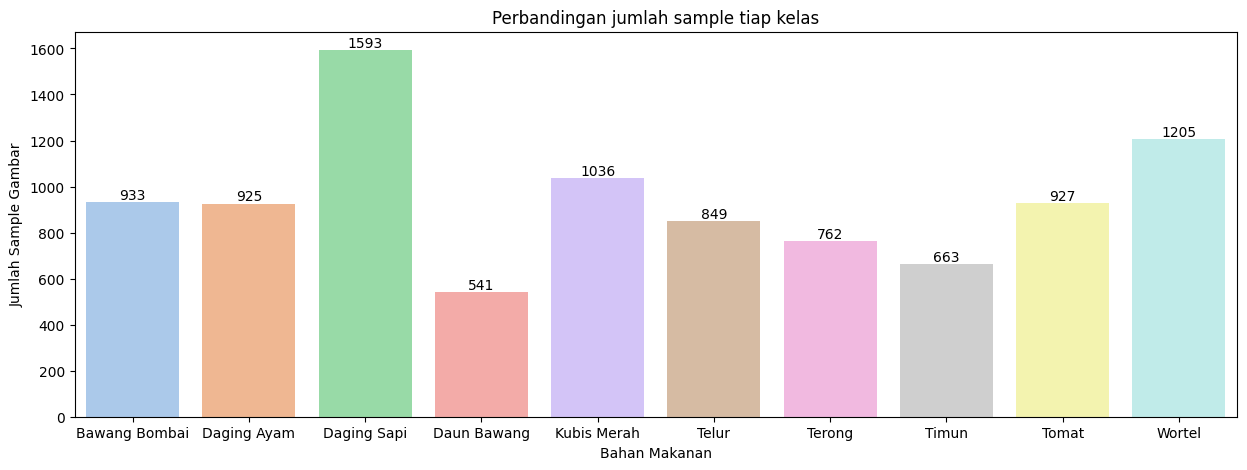

In [7]:
plt.figure(figsize = (15, 5))

chart = sns.barplot(x = bahan_makanan, y = jumlah_bahan, palette = 'pastel', hue = bahan_makanan)
for container in chart.containers:
    chart.bar_label(container, fontsize=10)
    
plt.title('Perbandingan jumlah sample tiap kelas')
plt.xlabel("Bahan Makanan")
plt.ylabel("Jumlah Sample Gambar")
plt.show()

# Split Dataset (train, val, test)

In [8]:
train_set = tf.keras.utils.image_dataset_from_directory(
    directory = dataset,
    image_size = (224, 224),
    label_mode = 'categorical',
    validation_split = 0.2,
    batch_size = 32, 
    subset = 'training',
    seed = 42
)

val_train_set = tf.keras.utils.image_dataset_from_directory(
    directory = dataset,
    image_size = (224, 224),
    label_mode = 'categorical',
    validation_split = 0.2,
    batch_size = 32,
    subset = 'validation',
    seed = 42
)

Found 9434 files belonging to 10 classes.
Using 7548 files for training.
Found 9434 files belonging to 10 classes.
Using 1886 files for validation.


In [9]:
validation_size = int(0.5 * len(val_train_set))
test_size = len(val_train_set) - validation_size

val_set = val_train_set.take(validation_size)
test_set = val_train_set.skip(validation_size)

# Transform Dataset

In [10]:
augmentation_model = tf.keras.Sequential([ 
    tf.keras.Input(shape = (224, 224, 3)),
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2, fill_mode = 'nearest'),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode = 'nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode = 'nearest')
])  

train_set = train_set.map(lambda x, y: (augmentation_model(x), y))

In [11]:
# Train Dataset
train_set = train_set.shuffle(buffer_size=1000).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation Dataset
val_set = val_set.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test Dataset
test_set = test_set.prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Training dataset size: {len(train_set)} batches")
print(f"Validation dataset size: {len(val_set)} batches")
print(f"Test dataset size: {len(test_set)} batches")

Training dataset size: 236 batches
Validation dataset size: 29 batches
Test dataset size: 30 batches


In [12]:
for images, labels in train_set.take(1):  
    print("Shape of images:", images.shape)      
    print("Shape of labels:", labels.shape)      

Shape of images: (32, 224, 224, 3)
Shape of labels: (32, 10)


# Calling the Pre-Trained Model (MobileNetV2)

In [13]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

In [14]:
for layer in base_model.layers:
  layer.trainable = False

# Create the Model

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.Flatten(),
    #tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation = 'sigmoid')
])

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │         627,210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,885,194 (11.01 MB)

 Trainable params: 627,210 (2.39 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Compiling The Model

In [28]:
optimizer = tf.optimizers.Adam()

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy', 'f1_score']
    
)

# Training The Model

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',  
    patience = 3,              
    restore_best_weights = True  
)

In [30]:
history = model.fit(
    train_set,
    validation_data = val_set,
    epochs = 100,
    callbacks = [early_stopping]
)

Epoch 1/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 193s 805ms/step - accuracy: 0.8370 - f1_score: 0.8332 - loss: 1.6460 - val_accuracy: 0.9720 - val_f1_score: 0.9720 - val_loss: 0.5427
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 180s 764ms/step - accuracy: 0.9708 - f1_score: 0.9714 - loss: 0.3685 - val_accuracy: 0.9784 - val_f1_score: 0.9787 - val_loss: 0.4747
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 191s 809ms/step - accuracy: 0.9853 - f1_score: 0.9849 - loss: 0.1715 - val_accuracy: 0.9752 - val_f1_score: 0.9762 - val_loss: 0.7332
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 184s 779ms/step - accuracy: 0.9902 - f1_score: 0.9906 - loss: 0.1261 - val_accuracy: 0.9494 - val_f1_score: 0.9441 - val_loss: 1.3691
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 159s 676ms/step - accuracy: 0.9892 - f1_score: 0.9890 - loss: 0.1352 - val_accuracy: 0.9591 - val_f1_score: 0.9646 - val_loss: 1.6117


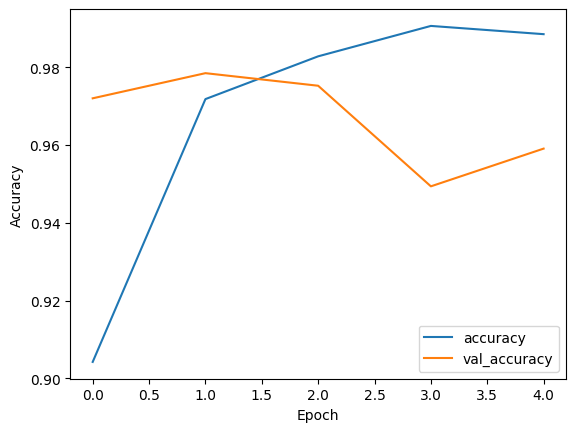

In [31]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Evaluate The Model with Unseen Data (Test Set)

In [32]:
model.evaluate(test_set)

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 617ms/step - accuracy: 0.9747 - f1_score: 0.9637 - loss: 0.8720


[0.760707676410675,
 0.9780793190002441,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.9940828 , 0.94610775, 0.97178674, 0.9126213 , 0.99539167,
        0.99487174, 0.95505613, 0.98684204, 1.        , 0.9902912 ],
       dtype=float32)>]

In [34]:
# directory_path = "./"
# model_name = "MobileNetV2.h5"

# model.save(os.path.join(directory_path, model_name))

#model.save("./MobileNetV2")
#model.save("./MobileNeTV2.keras")
# model.save("./mobilenetV2(softmax).h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image 1:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 1.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Terong
Predicted label: Terong


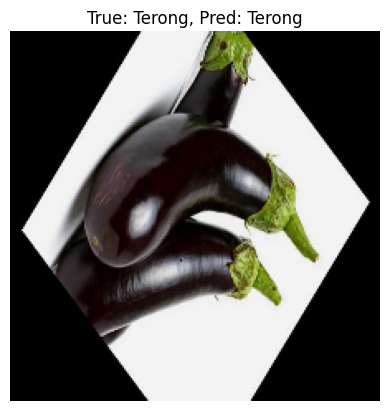

Image 2:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 1.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daun Bawang
Predicted label: Daun Bawang


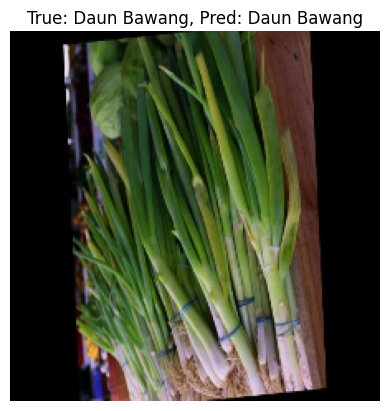

Image 3:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 1.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daging Sapi
Predicted label: Daging Sapi


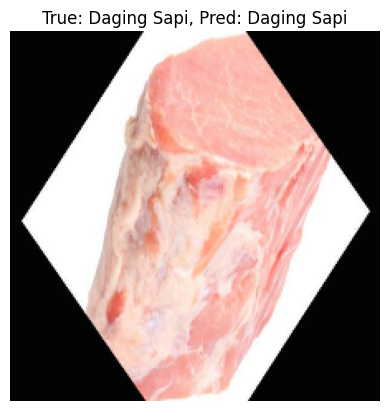

Image 4:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 1.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daging Ayam
Predicted label: Daging Ayam


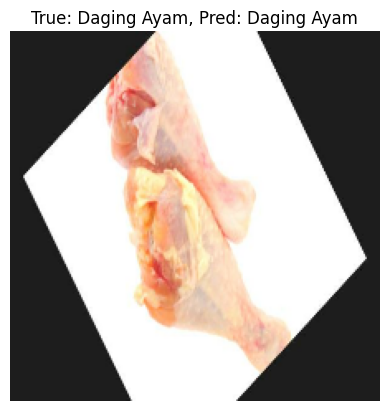

Image 5:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 1.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daging Sapi
Predicted label: Daging Sapi


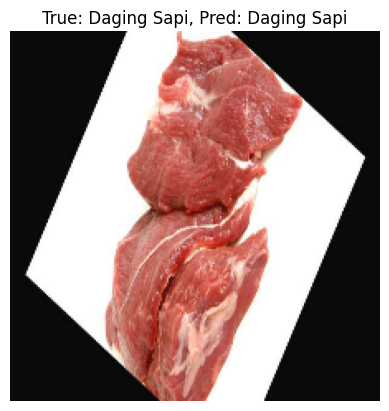

Image 6:
Probabilities:
label: Bawang Bombai, Probability: 1.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Bawang Bombai
Predicted label: Bawang Bombai


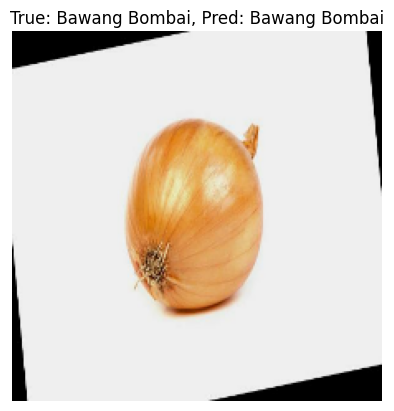

Image 7:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 1.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Timun
Predicted label: Timun


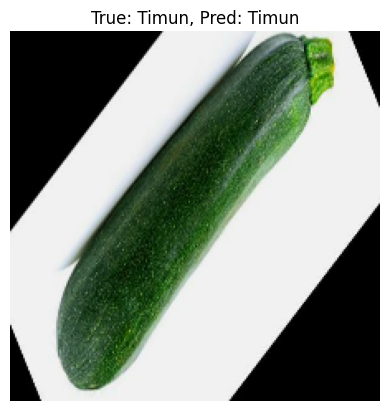

Image 8:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 1.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daging Sapi
Predicted label: Daging Sapi


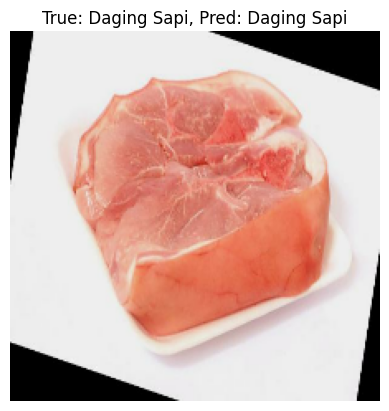

Image 9:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 1.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daging Sapi
Predicted label: Daging Sapi


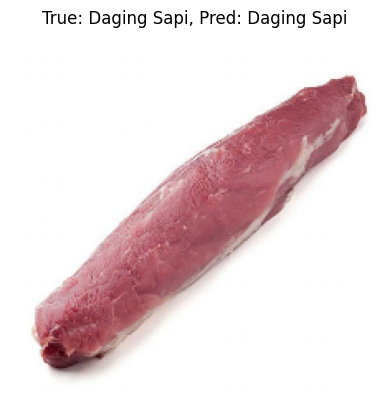

Image 10:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 1.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Telur
Predicted label: Telur


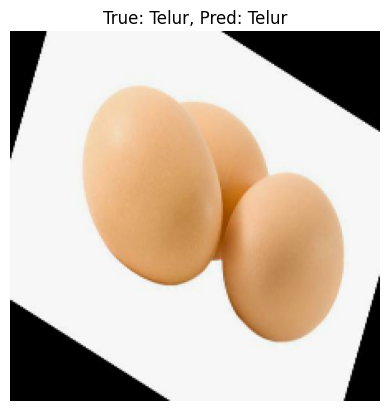

Image 11:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 1.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daun Bawang
Predicted label: Daun Bawang


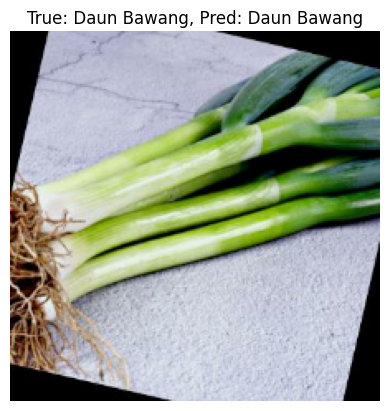

Image 12:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 1.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daun Bawang
Predicted label: Daun Bawang


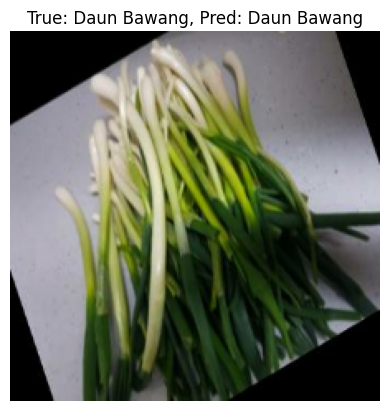

Image 13:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 1.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daging Sapi
Predicted label: Daging Sapi


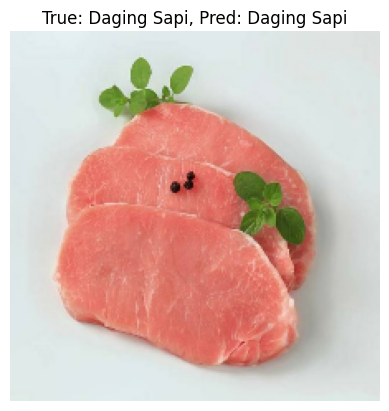

Image 14:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 1.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Terong
Predicted label: Terong


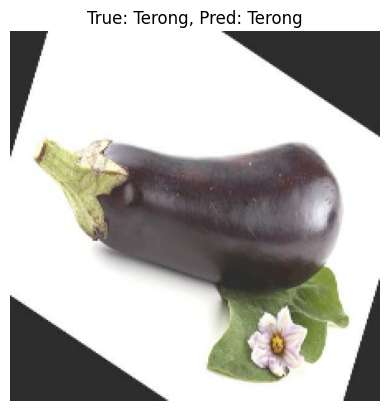

Image 15:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 1.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Kubis Merah
Predicted label: Kubis Merah


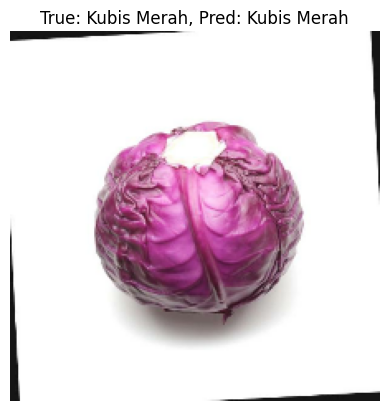

Image 16:
Probabilities:
label: Bawang Bombai, Probability: 1.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Bawang Bombai
Predicted label: Bawang Bombai


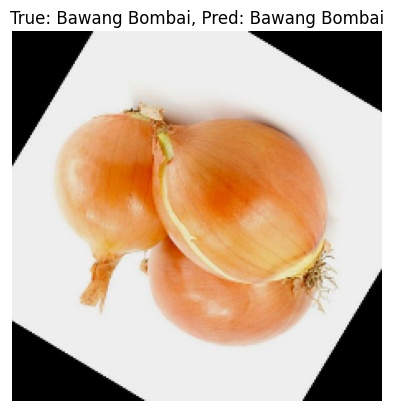

Image 17:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 1.00
label: Wortel, Probability: 0.00
True label: Tomat
Predicted label: Tomat


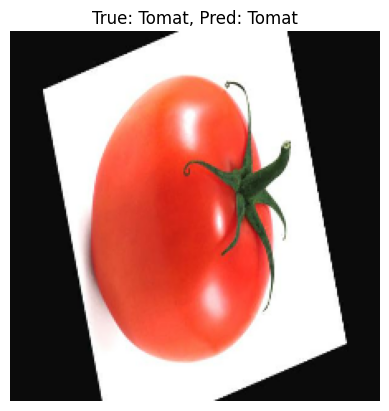

Image 18:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 1.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daging Sapi
Predicted label: Daging Sapi


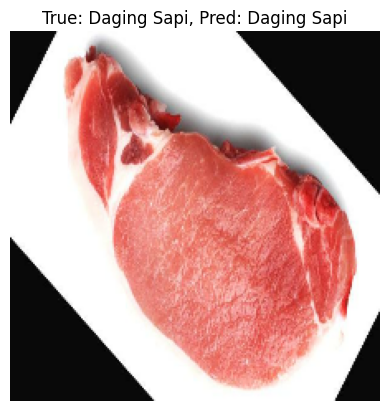

Image 19:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 1.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daging Sapi
Predicted label: Daging Sapi


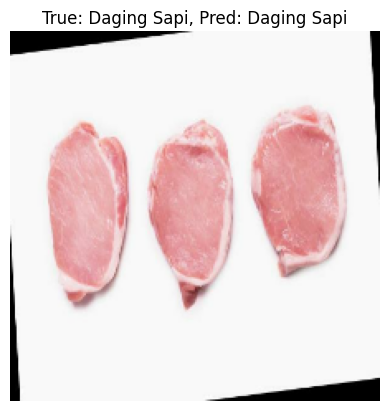

Image 20:
Probabilities:
label: Bawang Bombai, Probability: 1.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Bawang Bombai
Predicted label: Bawang Bombai


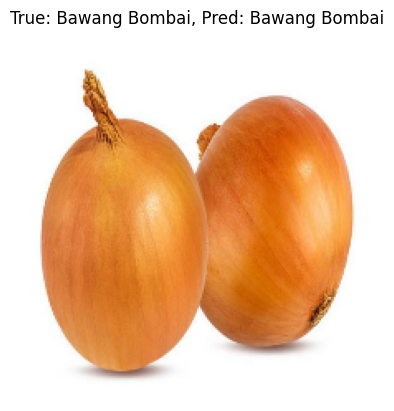

Image 21:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 1.00
True label: Wortel
Predicted label: Wortel


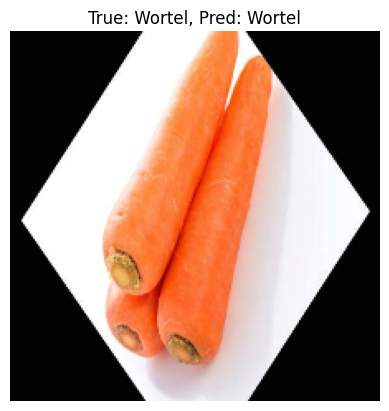

Image 22:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 1.00
label: Wortel, Probability: 0.00
True label: Tomat
Predicted label: Tomat


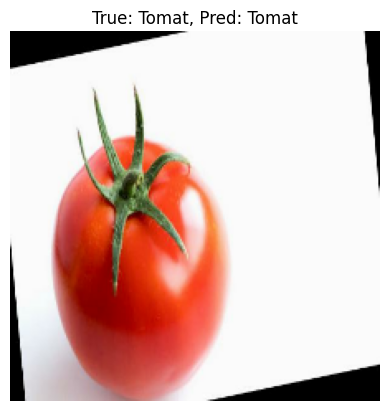

Image 23:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 1.00
label: Wortel, Probability: 0.00
True label: Tomat
Predicted label: Tomat


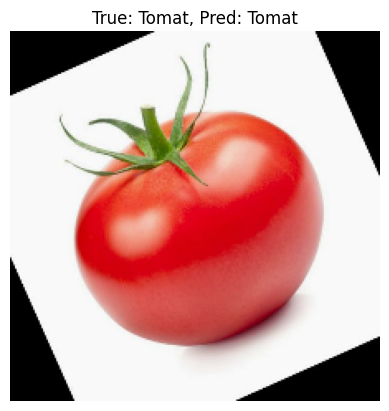

Image 24:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 1.00
label: Wortel, Probability: 0.00
True label: Tomat
Predicted label: Tomat


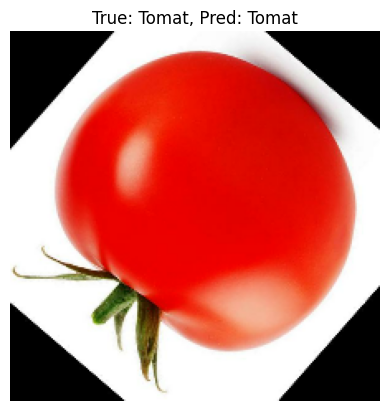

Image 25:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 1.00
True label: Wortel
Predicted label: Wortel


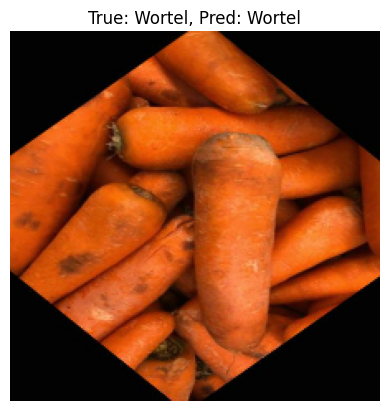

Image 26:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 1.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Terong
Predicted label: Terong


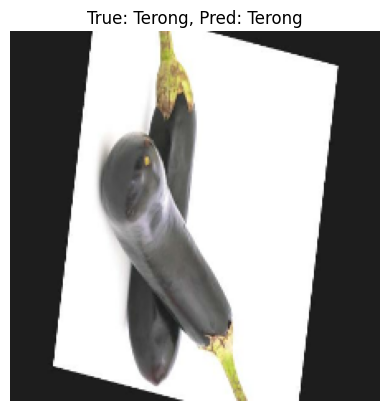

Image 27:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 1.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Daun Bawang
Predicted label: Daun Bawang


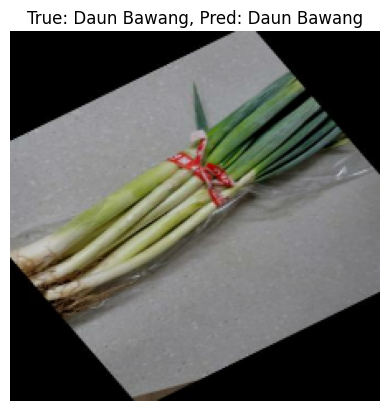

Image 28:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 1.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Timun
Predicted label: Timun


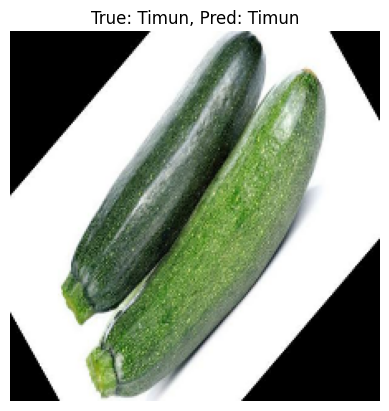

Image 29:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 1.00
True label: Wortel
Predicted label: Wortel


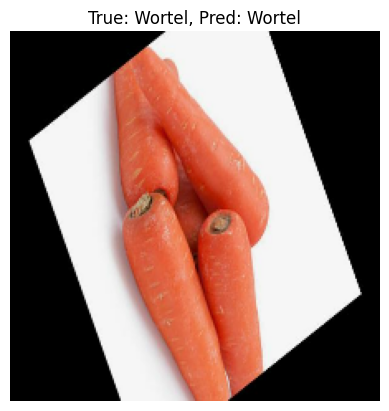

Image 30:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 1.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Telur
Predicted label: Telur


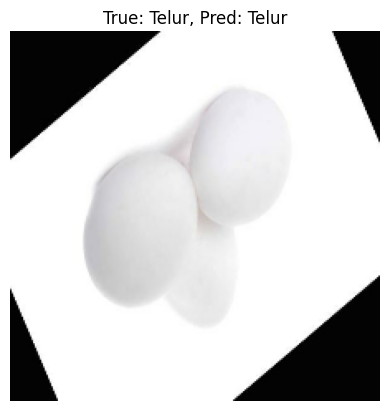

Image 31:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 1.00
label: Telur, Probability: 0.00
label: Terong, Probability: 0.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Kubis Merah
Predicted label: Kubis Merah


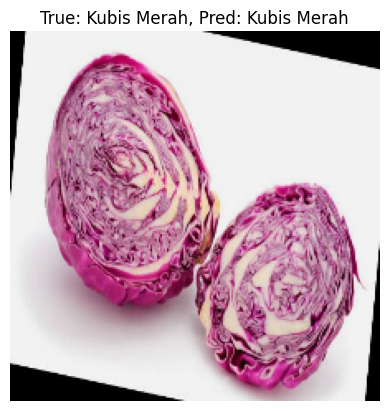

Image 32:
Probabilities:
label: Bawang Bombai, Probability: 0.00
label: Daging Ayam, Probability: 0.00
label: Daging Sapi, Probability: 0.00
label: Daun Bawang, Probability: 0.00
label: Kubis Merah, Probability: 0.00
label: Telur, Probability: 0.00
label: Terong, Probability: 1.00
label: Timun, Probability: 0.00
label: Tomat, Probability: 0.00
label: Wortel, Probability: 0.00
True label: Terong
Predicted label: Terong


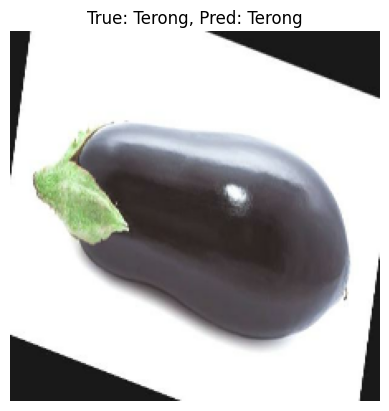

In [33]:
# Daftar bahan makanan
bahan_makanan = ['Bawang Bombai', 'Daging Ayam', 'Daging Sapi', 'Daun Bawang', 
                 'Kubis Merah', 'Telur', 'Terong', 'Timun', 'Tomat', 'Wortel']

# Ambil satu batch dari test set
for images, labels in test_set.take(1):  
    # Dapatkan prediksi model
    predictions = model.predict(images)
    
    for i in range(len(images)):
        # Label sebenarnya
        true_label_idx = tf.argmax(labels[i]).numpy()
        true_label = bahan_makanan[true_label_idx]
        
        # Label prediksi
        pred_label_idx = tf.argmax(predictions[i]).numpy()
        pred_label = bahan_makanan[pred_label_idx]
        
        # Probabilitas tiap label untuk gambar ini
        probabilities = [
            f"label: {bahan_makanan[j]}, Probability: {predictions[i][j]:.2f}" 
            for j in range(len(bahan_makanan))
        ]
        
        # Menampilkan informasi
        print(f"Image {i+1}:")
        print("Probabilities:")
        for prob in probabilities:
            print(prob)
        print(f"True label: {true_label}")
        print(f"Predicted label: {pred_label}")
        
        # Menampilkan gambar
        plt.imshow(images[i].numpy().astype("uint8"))  # Ubah tensor ke numpy array
        plt.title(f"True: {true_label}, Pred: {pred_label}")  # Label sebenarnya dan prediksi
        plt.axis("off")  # Matikan axis pada plot
        plt.show()